In [ ]:
# !kaggle datasets download -d bahushruth/legalclausedataset -p /content


In [ ]:
# !unzip -j /content/legalclausedataset.zip -d /content/Data_sets


In [1]:
import pandas as pd
import glob
import re
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt

In [3]:
# # Specify the directory containing CSV files (replace with your actual path)
# data_dir = "/content/Data_sets/"  # Update with your directory path

# # Create an empty list to store all dataframes
# all_paragraphs = []
# all_classes = []

# # Get a list of all CSV files using glob (more efficient for large folders)
# csv_files = glob.glob(data_dir + "*.csv")

# # Iterate through each CSV file
# for file in csv_files:
#     try:
#         # Read the CSV file into a Pandas DataFrame
#         df = pd.read_csv(file)

#         # Extract specific columns (modify column names if needed)
#         paragraphs = df['clause_text'].tolist()
#         classes = df['clause_type'].tolist()

#         # Append extracted data to the respective lists
#         all_paragraphs.extend(paragraphs)
#         all_classes.extend(classes)

#     except FileNotFoundError:
#         print(f"Error: File '{file}' not found. Skipping...")

#     except pd.errors.ParserError as e:
#         print(f"Error parsing '{file}': {e}. Skipping...")

# # Create a single DataFrame with all collected data
# df = pd.DataFrame({'clause_text': all_paragraphs, 'clause_type': all_classes})

# print("All CSV files processed successfully!")

All CSV files processed successfully!


In [3]:
df = pd.read_csv('Contract_Clauses.csv')

In [4]:
df = df.iloc[:, 1:]

In [5]:
df

,clause_text,clause_type
0,Distributions. Distributions shall be made to ...,distributions
1,"Distributions. The Trustee, as of the First Se...",distributions
2,Distributions. Distributions shall be made to ...,distributions
3,"Distributions. (a) On each Distribution Date, ...",distributions
4,Distributions. (a) The Trust Securities repres...,distributions
...,...,...
150876,Term. The effective date of this agreement (th...,term
150877,Term. The Company shall have perpetual existence.,term
150878,Term. This Sublease will be for a term beginni...,term
150879,Term. This Agreement shall commence on the dat...,term


In [52]:
unique_types = df['clause_type'].unique()

print(unique_types)

['distributions' 'release' 'enforcement' 'reports'
 'entire-agreement-amendment' 'parties-in-interest' 'employees'
 'base-salary' 'payment' 'governing-law-jurisdiction'
 'termination-of-agreement' 'preamble' 'expenses' 'financial-information'
 'tax-withholding' 'indemnity' 'construction' 'reimbursement' 'security'
 'scope' 'redemption' 'termination-for-cause' 'grant-of-option'
 'closing-date' 'merger' 'organization-and-qualification' 'appointment'
 'force-majeure' 'therefore' 'exercise-of-option' 'consents'
 'intellectual-property-rights' 'r-e-c-i-t-a-l-s' 'fractional-shares'
 'withholding' 'third-party-beneficiaries' 'grant-of-security-interest'
 'resignation' 'definition' 'choice-of-law' 'limited_liability'
 'notices-etc' 'parking' 'services' 'withholding-taxes'
 'change-in-control' 'bankruptcy' 'integration' 'waiver'
 'application-of-proceeds' 'condemnation' 'interpretation' 'amendment'
 'other' 'utilities' 'no-conflicts' 'organization-and-good-standing'
 'representations-warranties

In [6]:
num_unique_types = df['clause_type'].nunique()

print(f"Number of unique clause types: {num_unique_types}")

Number of unique clause types: 395


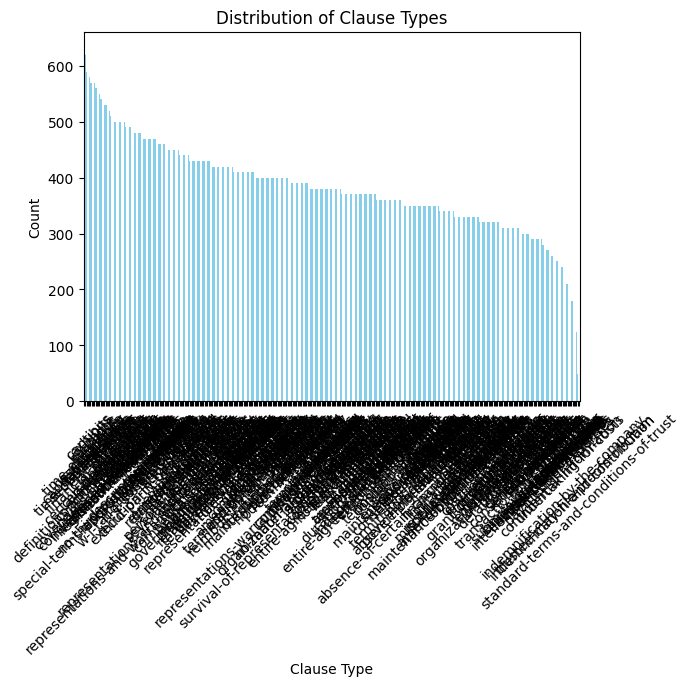

In [10]:
unique_types_counts = df['clause_type'].value_counts()

unique_types_counts.plot(kind='bar', color='skyblue')

plt.xlabel('Clause Type')
plt.ylabel('Count')
plt.title('Distribution of Clause Types')

plt.xticks(rotation=45)

plt.show()

**Cleaning**

In [7]:
import nltk
from nltk.corpus import stopwords
import spacy

In [8]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sukan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
# !python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.1/12.8 MB 1.1 MB/s eta 0:00:12
      --------------------------------------- 0.2/12.8 MB 3.0 MB/s eta 0:00:05
     -- ------------------------------------- 0.8/12.8 MB 5.6 MB/s eta 0:00:03
     --- ------------------------------------ 1.0/12.8 MB 5.3 MB/s eta 0:00:03
     --- ------------------------------------ 1.2/12.8 MB 5.0 MB/s eta 0:00:03
     --- ------------------------------------ 1.2/12.8 MB 5.0 MB/s eta 0:00:03
     --- ------------------------------------ 1.2/12.8 MB 5.0 MB/s eta 0:00:03
     ---- ----------------------------------- 1.4/12.8 MB 3.7 MB/s eta 0:00:04
     ---- ----------------------------------- 1.4/12.8 MB 3.7 MB/s eta 0:00:04
     ----- ---------------------------------- 1.8/12.8 MB 3.8 MB/s eta 0:00:03
     ------ --------------------------------- 2.0/12.8 MB 3.8 MB/s eta 0:00:03
     ------ --------------------------------- 2.2/12.8 MB 3

In [9]:
nlp = spacy.load("en_core_web_sm")

In [10]:
def clean_text(text):

    # Lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)

    # Handle common abbreviations (optional, modify as needed)
    text = re.sub(r"(§ )|(section )", "section ", text)
    text = re.sub(r"(para )|(paragraph )", "paragraph ", text)

    # Remove stop words
    text = " ".join([word for word in text.split() if word not in stop_words])

    # Lemmatization
    doc = nlp(text)
    text = " ".join([token.lemma_ for token in doc])

    return text

In [11]:
df["clause_text"] = df["clause_text"].apply(clean_text)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df['clause_text'], df['clause_type'], test_size=0.2, random_state=42)

In [16]:
le = LabelEncoder()

In [17]:
vectorizer = TfidfVectorizer(max_features=3000)
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

Ensemble Method Start

In [78]:
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

In [74]:
# Define different classifiers
clf1 = MLPClassifier(hidden_layer_sizes=(50, 50, 50), activation='relu', max_iter=500, solver='adam')
clf2 = LogisticRegression(max_iter=500)
clf3 = SVC(kernel='linear')

In [77]:
# Create an ensemble of classifiers
ensemble = VotingClassifier(estimators=[('mlp', clf1), ('lr', clf2), ('svc', clf3)], voting='hard')

In [79]:
# Fit the ensemble to the training data
ensemble.fit(X_train_features, y_train)

VotingClassifier(estimators=[('mlp',
                              MLPClassifier(hidden_layer_sizes=(50, 50, 50),
                                            max_iter=500)),
                             ('lr', LogisticRegression(max_iter=500)),
                             ('svc', SVC(kernel='linear'))])

In [80]:
# Make predictions and evaluate
y_pred = ensemble.predict(X_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Accuracy: {accuracy:.4f}")

Ensemble Accuracy: 0.7964


In [82]:
import joblib

In [18]:
joblib.dump(vectorizer, 'ensemble_model_tfidf_vectorizer.pkl')

['ensemble_model_tfidf_vectorizer.pkl']

In [86]:
joblib.dump(ensemble, 'ensemble_model.pkl')
print("Model saved successfully!")

Model saved successfully!


In [20]:
loaded_model = joblib.load('ensemble_model.pkl')
loaded_vectorizer = joblib.load('ensemble_model_tfidf_vectorizer.pkl')

In [31]:
# Example paragraph to test
paragraph_to_test = """

The Parties agree to the following terms and conditions:

"""

# Clean the paragraph
paragraph_to_test_cleaned = clean_text(paragraph_to_test)

# Get para vectors for the paragraph
paragraph_features = loaded_vectorizer.transform([paragraph_to_test_cleaned])

In [32]:
predicted_clause_type = loaded_model.predict(paragraph_features)
predicted_clause_type

array(['conditions'], dtype=object)

Ensemble Method End

In [ ]:
# import seaborn as sns

In [ ]:
# # Heatmap with color gradient
# sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d")

# # Labels for axes and title
# plt.xlabel("Predicted Clause Type")
# plt.ylabel("True Clause Type")
# plt.title("Confusion Matrix")

# # Display the plot
# plt.show()